In [1]:
##### change filename to numpy image and label

### get filename
import glob

busyFilelist = glob.glob("C:/Users/Chaya/Google Drive/Competation/Carpark/A/busy/*")
freeFilelist = glob.glob("C:/Users/Chaya/Google Drive/Competation/Carpark/A/free/*")
limit = 250
filelist = busyFilelist[0:limit] + freeFilelist[0:limit]

# shuffle
from random import shuffle
shuffle(filelist)

### get image
from PIL import Image
import numpy as np

imsize = 224

im = np.empty((1,imsize,imsize,3), int)
for filename in filelist:
    img = Image.open(filename).resize((imsize,imsize))
    im = np.append(im, ((np.asarray(img, dtype="int32")/127.5) - 1).reshape((1,imsize,imsize,3)), axis=0)
im = im[1:]

### get label
label = []
n = 0
for filename in filelist:
    if filename.split("/")[-1][0:4] == 'busy':
        label.append(1)
    else:
        label.append(0)
        
print(im.shape)
print(len(label))

(500, 224, 224, 3)
500


In [2]:
import tensorflow as tf

keras = tf.keras
bsize = 10
X = tf.convert_to_tensor(im[0:450], dtype=tf.float64)
y = tf.convert_to_tensor(label[0:450], dtype=tf.float64)
Xv = tf.convert_to_tensor(im[-50:], dtype=tf.float64)
yv = tf.convert_to_tensor(label[-50:], dtype=tf.float64)
train = tf.data.Dataset.from_tensor_slices((X, y))
validation = tf.data.Dataset.from_tensor_slices((Xv, yv))
validation_batches = validation.batch(bsize)
train_batches = train.batch(bsize)

del im
del label

In [3]:
# Extract feature from MobileNet
base_model = tf.keras.applications.MobileNetV2(input_shape=(imsize, imsize, 3), include_top=False, weights='imagenet')

for image_batch, label_batch in train_batches.take(1):
    pass

print(image_batch.shape)

feature = base_model(image_batch)
print(feature.shape)

(10, 224, 224, 3)

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

(10, 7, 7, 1280)


In [4]:
# freeze model
base_model.trainable = False
# base_model.summary()

In [5]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_average = global_average_layer(feature)
print(feature_average.shape)

(10, 1280)


In [6]:
prediction_layer = keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_average)
print(prediction_batch.shape)

(10, 1)


In [7]:
model = tf.keras.Sequential([base_model, global_average_layer, prediction_layer])

In [8]:
base_learning_rate = 0.0005
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss='binary_crossentropy',
              metrics=['accuracy'])
# model.summary()
epochs = 20

In [9]:
history = model.fit(train_batches, epochs=epochs, validation_data=validation_batches)

Epoch 1/20
45/45 [==============================] - 43s 948ms/step - loss: 1.5461 - accuracy: 0.7244 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/20
45/45 [==============================] - 42s 926ms/step - loss: 0.7373 - accuracy: 0.8489 - val_loss: 1.9695 - val_accuracy: 0.8200
Epoch 3/20
45/45 [==============================] - 42s 937ms/step - loss: 0.5116 - accuracy: 0.9133 - val_loss: 1.7375 - val_accuracy: 0.8000
Epoch 4/20
45/45 [==============================] - 43s 965ms/step - loss: 0.4408 - accuracy: 0.9222 - val_loss: 1.6971 - val_accuracy: 0.8200
Epoch 5/20
45/45 [==============================] - 45s 998ms/step - loss: 0.4010 - accuracy: 0.9422 - val_loss: 1.6162 - val_accuracy: 0.8600
Epoch 6/20
45/45 [==============================] - 47s 1s/step - loss: 0.2953 - accuracy: 0.9422 - val_loss: 1.3146 - val_accuracy: 0.9000
Epoch 7/20
45/45 [==============================] - 47s 1s/step - loss: 0.2662 - accuracy: 0.9667 - val_loss: 1.2811 - val_accuracy: 0.90

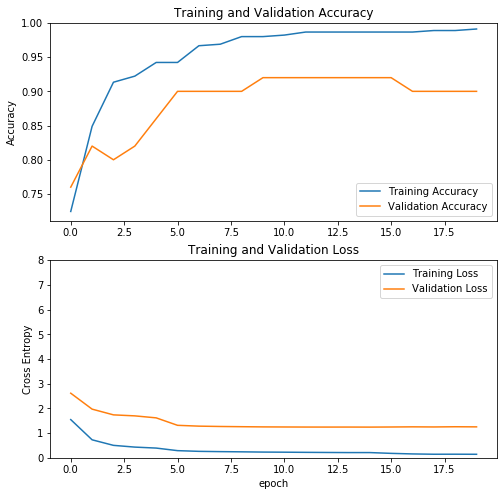

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,8.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()